In [1]:
import tensorflow as tf
from datetime import timedelta
import numpy as np
from util_input_output_model import *
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

## Preparing X, Y

In [2]:
print("Enter timestep : ",end=' ')
timesteps = int(input())
print(timesteps)

Enter timestep :  24


In [3]:
import pandas as pd
from collections import defaultdict

provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla']
'''
def prepare_train_data():
    path = f'./data/Train/fire_integrated/'
    data = {}

    X = defaultdict(lambda: list())
    Y = defaultdict(lambda: list())

    hour_step = timedelta(hours=timesteps-1)

    # Time we have to forecast
    predict_at = pd.date_range("2016-03-04 00:00:00", "2019-03-17 23:00:00", freq='6H')

    for province in provinces:
        # Read preprocessed data
        df = pd.read_csv(path+f'{province}_fire_integrated.csv', index_col=0, parse_dates=True)
        data[province] = df

        # Create Input & Output of model
        for base in predict_at:

            if base-hour_step not in df.index : continue
            x = df.loc[base-hour_step: base].drop(['PM2.5'], axis=1)

            till = base+timedelta(hours=72)
            if till not in df.index: break
            y = df.loc[base+timedelta(hours=1): till, ['PM2.5']]

            X[province].append(x)
            Y[province].append(y)

    return data, X, Y
'''

'\ndef prepare_train_data():\n    path = f\'./data/Train/fire_integrated/\'\n    data = {}\n\n    X = defaultdict(lambda: list())\n    Y = defaultdict(lambda: list())\n\n    hour_step = timedelta(hours=timesteps-1)\n\n    # Time we have to forecast\n    predict_at = pd.date_range("2016-03-04 00:00:00", "2019-03-17 23:00:00", freq=\'6H\')\n\n    for province in provinces:\n        # Read preprocessed data\n        df = pd.read_csv(path+f\'{province}_fire_integrated.csv\', index_col=0, parse_dates=True)\n        data[province] = df\n\n        # Create Input & Output of model\n        for base in predict_at:\n\n            if base-hour_step not in df.index : continue\n            x = df.loc[base-hour_step: base].drop([\'PM2.5\'], axis=1)\n\n            till = base+timedelta(hours=72)\n            if till not in df.index: break\n            y = df.loc[base+timedelta(hours=1): till, [\'PM2.5\']]\n\n            X[province].append(x)\n            Y[province].append(y)\n\n    return data, X, Y

In [103]:
'''
def prepare_test_data(Train_data):
    path = "./data/Test/fire_integrated/"
    data = {}

    predict_at = pd.date_range("2019-3-18 12:00:00", '2020-03-15 18:00:00', freq='6H')

    hour_step = timedelta(hours=timesteps-1)
    X = defaultdict(lambda: list())
    Y = defaultdict(lambda: list())

    for province in provinces:
        df = pd.read_csv(path+f'{province}_fire_integrated.csv', index_col=0, parse_dates=True)
        data[province] = df

        for base in predict_at:
            
            if base-hour_step < df.index[0]:
                dif = (df.index[0] - (base-hour_step)).seconds//3600
                a = Train_data[province].iloc[-dif:]
                b = df.loc[:base]
                x = a.append(b).drop(['PM2.5'], axis=1)
            else:
                x = df.loc[base-hour_step: base].drop(['PM2.5'],axis=1)

            till = base+timedelta(hours=72)
            y = df.loc[base+timedelta(hours=1): till, ['PM2.5']]

            X[province].append(x)
            Y[province].append(y)
    return data, X, Y
'''

In [4]:
Train_data, X_train, Y_train = prepare_train_data(timesteps)

In [5]:
Test_data, X_test, Y_test = prepare_test_data(Train_data, timesteps)

dif : 19
2019-03-18 08:00:00
base = 2019-03-18 12:00:00
dif : 13
2019-03-18 08:00:00
base = 2019-03-18 18:00:00
dif : 7
2019-03-18 08:00:00
base = 2019-03-19 00:00:00
dif : 1
2019-03-18 08:00:00
base = 2019-03-19 06:00:00


In [8]:
'''
from sklearn.preprocessing import MinMaxScaler

def scale_data(X, Y, data):
    x_scalers, y_scalers = {}, {}

    X_scaled = defaultdict(lambda: list())
    Y_scaled = defaultdict(lambda: list())

    for province in provinces:
        # Standardize x, y
        x = data[province].drop(['PM2.5'], axis=1)
        y = data[province][['PM2.5']]

        x_scaler = MinMaxScaler().fit(x)
        y_scaler = MinMaxScaler().fit(y)

        # Save the scaler for later use
        for e in X[province]:
            X_scaled[province].append(x_scaler.transform(e))
            x_scalers[province] = x_scaler
        for e in Y[province]:
            Y_scaled[province].append(y_scaler.transform(e))
            y_scalers[province] = y_scaler
    
    return x_scalers, y_scalers, X_scaled, Y_scaled
'''

In [6]:
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)
x_test_scalers, y_test_scalers, X_test_scaled, Y_test_scaled = scale_data(X_test, Y_test, Test_data)

## Reshaping input

In [7]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Chanthaburi
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Chiang Mai
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Kanchanaburi
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Songkhla
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)



In [27]:
'''

x_train = x_.reshape((x_.shape[0], timesteps, n_features))
y_train = y_.reshape((y_.shape[0], 72))
'''

In [28]:
'''
print(f'x : {x_train.shape}')
print(f'y : {y_train.shape}')
'''

x : (1452, 12, 7)
y : (1452, 72)


## Building Model

In [8]:
print(f"timesteps : {timesteps}")

timesteps : 24


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

n_features = 7
# define model

model = Sequential([
    LSTM(200, activation='relu', input_shape=(timesteps, n_features)),
    Dense(144, activation='relu'),
    Dense(72)
])
model.compile(optimizer='adam', loss='mse')

In [20]:
provinces

['Bangkok', 'Chanthaburi', 'Chiang Mai', 'Kanchanaburi', 'Songkhla']

In [53]:
x_['Songkhla']['Test'].shape

(1454, 24, 7)

In [56]:
province = 'Songkhla'
x_feed, y_feed = x_[province]['Test'], y_[province]['Test']
history = model.fit(x_feed, y_feed, epochs=50, batch_size=32)

Epoch 1/50
46/46 [==============================] - 1s 29ms/step - loss: 0.0141
Epoch 2/50
46/46 [==============================] - 2s 42ms/step - loss: 0.0137
Epoch 3/50
46/46 [==============================] - 2s 42ms/step - loss: 0.0134
Epoch 4/50
46/46 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 5/50
46/46 [==============================] - 2s 41ms/step - loss: 0.0136
Epoch 6/50
46/46 [==============================] - 2s 51ms/step - loss: 0.0130
Epoch 7/50
46/46 [==============================] - 2s 39ms/step - loss: 0.0127
Epoch 8/50
46/46 [==============================] - 2s 40ms/step - loss: 0.0125
Epoch 9/50
46/46 [==============================] - 2s 42ms/step - loss: 0.0126
Epoch 10/50
46/46 [==============================] - 2s 43ms/step - loss: 0.0122
Epoch 11/50
46/46 [==============================] - 2s 41ms/step - loss: 0.0126
Epoch 12/50
46/46 [==============================] - 2s 43ms/step - loss: 0.0125
Epoch 13/50
46/46 [==================

### Evaluate on train

In [57]:
model.evaluate(x_feed, y_feed)

46/46 [==============================] - 1s 10ms/step - loss: 0.0079


0.00786261074244976

### Evaluate on test

In [ ]:
#model.evaluate(x_test, y_test)

In [58]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_feed)
rmse = []
print('province :', province)
for i in range(len(pred)):
    p = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = y_test_scalers[province].inverse_transform(y_feed[i].reshape((-1,1)))
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Songkhla


6.65556512560129

province = Songkhla


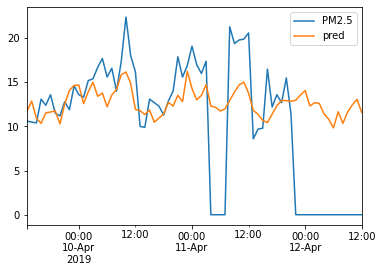

In [59]:
i = 88
print('province =',province)
h = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();

## Save the model
- `Bangkok`

In [28]:
if not os.path.exists("./Models/Bangkok.h5"):
    model.save("./Models/Bangkok.h5")
    print("Bangkok model : saved")
else: print("Bangkok model is ready")

Bangkok model is ready


In [29]:
if not os.path.exists("./Models/Chanthaburi.h5"):
    model.save("./Models/Chanthaburi.h5")
    print("Chanthaburi model : saved")
else: print("Chanthaburi model is ready")

Chanthaburi model : saved


In [43]:
if not os.path.exists("./Models/Chiang Mai.h5"):
    model.save("./Models/Chiang Mai.h5")
    print("Chiang Mai model : saved")
else: print("Chiang Mai model is ready")

Chiang Mai model : saved


In [52]:
if not os.path.exists("./Models/Kanchanaburi.h5"):
    model.save("./Models/Kanchanaburi.h5")
    print("Kanchanaburi model : saved")
else: print("Kanchanaburi model is ready")

Kanchanaburi model : saved


In [60]:
if not os.path.exists("./Models/Songkhla.h5"):
    model.save("./Models/Songkhla.h5")
    print("Songkhla model : saved")
else: print("Songkhla model is ready")

Songkhla model : saved


In [52]:
628128/6/72

1454.0

In [19]:
from tensorflow.keras.models import load_model
p = load_model('./Models/Bangkok.h5')
p.evaluate(x_feed, y_feed)

46/46 [==============================] - 1s 10ms/step - loss: 0.0049


0.004932745825499296